In [1]:
import pandas as pd
import plotnine as p9
from pathlib import Path
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as p9

import skmisc
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

In [2]:
def invnorm(x):
    return stats.norm.ppf((x.rank() - 0.5)/x.count())

In [4]:
results_dir = "../../data/processed/results"
sample = 'dnaid2023'


In [5]:
#TV5490A: library_13_1
counts_file = "/nfs/nas22/fs2202/biol_micro_bioinf_nccr/hardt/nguyenb/tnseq/"\
              "data/processed/results/dnaid2023/dnaid2023_counts_TV5490A.txt"

mapping_file = "/nfs/nas22/fs2202/biol_micro_bioinf_nccr/hardt/nguyenb/tnseq/"\
                "data/processed/results/dnaid2023/dnaid2023_features_TV5490A.txt"

results_file = "/nfs/nas22/fs2202/biol_micro_bioinf_nccr/hardt/nguyenb/tnseq/"\
                "data/processed/results/dnaid2023/dnaid2023_results_TV5490A.txt"

omapping_file = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/"\
                "chris/hardt/nguyenb/tnseq_mapping_2031/scratch/library_13_1/barcode_map.txt"

In [6]:
old_map = pd.read_table(omapping_file, header=None)
df = (pd.read_csv(counts_file, sep=" ")
    .drop(['Position', 'Element', 'Strand', 'Feature', 'ShortName' ], axis=1))
features = pd.read_csv(mapping_file, sep=" ")
results = pd.read_csv(results_file, sep=" ")

,Position,Element,Strand,Feature,ShortName
TCGGTACTCCCTGTGAC,100,NC_017719.1,minus,gene-SL1344_RS24690,sul2
CCCTTTCAGCTGTGCAC,8453,NC_017719.1,plus,gene-SL1344_RS24735,aph(3'')-Ib
TCACCCCGCTCAAAATA,2912,NC_017719.1,minus,gene-SL1344_RS24705,SL1344_RS24705
GAGCAGATCACCTTGGC,7708,NC_017719.1,plus,gene-SL1344_RS24730,SL1344_RS24730
CGAGAAGCAATAAATCT,2334,NC_017719.1,plus,gene-SL1344_RS24700,SL1344_RS24700


In [7]:
df2 = df.apply(lambda x: x/x.sum())

<AxesSubplot:>

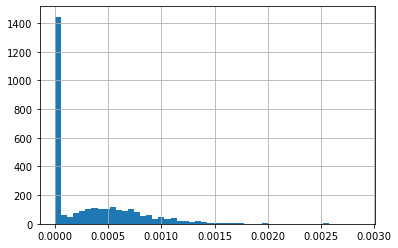

In [79]:
df2['al962-d1-feces'].hist(bins=50)

In [8]:
df3 = df2.apply(invnorm)

<AxesSubplot:>

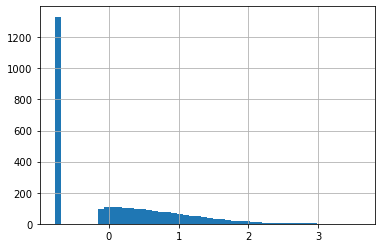

In [73]:
df3['al962-d1-feces'].hist(bins=50)

In [9]:
df4 = np.log2(df2+1)

<AxesSubplot:>

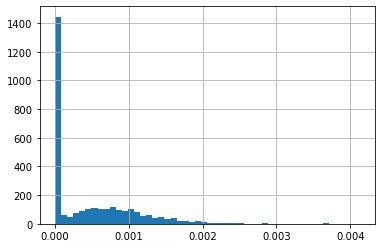

In [80]:
df4['al962-d1-feces'].hist(bins=50)

In [10]:
df2.corr()

,unenriched_inoculum-d0-inoculum,inoculum-d0-inoculum,al960-d1-feces,al961-d1-feces,al962-d1-feces,al963-d1-feces,al964-d1-feces,al965-d1-feces,al966-d1-feces,al967-d1-feces,al960-d2-feces,al961-d2-feces,al962-d2-feces,al963-d2-feces,al964-d2-feces,al965-d2-feces,al966-d2-feces,al967-d2-feces
unenriched_inoculum-d0-inoculum,1.000000,0.954982,0.855332,0.924640,0.904565,0.911525,0.911289,0.701928,0.854658,0.641007,0.777824,0.720382,0.785385,0.506969,0.837502,0.682366,0.839643,0.557628
inoculum-d0-inoculum,0.954982,1.000000,0.879162,0.944897,0.928478,0.929830,0.922848,0.707194,0.878329,0.672566,0.775348,0.741808,0.821990,0.536590,0.863085,0.693182,0.862835,0.607235
al960-d1-feces,0.855332,0.879162,1.000000,0.915226,0.912330,0.916239,0.904372,0.682048,0.881507,0.648165,0.873035,0.727916,0.832514,0.542566,0.852890,0.688231,0.843108,0.562613
al961-d1-feces,0.924640,0.944897,0.915226,1.000000,0.969120,0.973433,0.963243,0.730821,0.919331,0.701748,0.818461,0.816459,0.888285,0.575249,0.917959,0.733042,0.913484,0.638176
al962-d1-feces,0.904565,0.928478,0.912330,0.969120,1.000000,0.966052,0.954655,0.723795,0.917009,0.694824,0.813844,0.783516,0.929686,0.581566,0.910572,0.727087,0.901070,0.620964
al963-d1-feces,0.911525,0.929830,0.916239,0.973433,0.966052,1.000000,0.961115,0.733115,0.917533,0.684542,0.819026,0.790782,0.888927,0.596910,0.912841,0.737103,0.905804,0.612496
al964-d1-feces,0.911289,0.922848,0.904372,0.963243,0.954655,0.961115,1.000000,0.726313,0.906588,0.668679,0.811316,0.781781,0.863645,0.560544,0.940812,0.726118,0.891703,0.588546
al965-d1-feces,0.701928,0.707194,0.682048,0.730821,0.723795,0.733115,0.726313,1.000000,0.689756,0.487866,0.586062,0.603893,0.640809,0.429182,0.680574,0.967592,0.663985,0.416292
al966-d1-feces,0.854658,0.878329,0.881507,0.919331,0.917009,0.917533,0.906588,0.689756,1.000000,0.659759,0.756050,0.735518,0.841280,0.538636,0.852455,0.695876,0.942801,0.576993
al967-d1-feces,0.641007,0.672566,0.648165,0.701748,0.694824,0.684542,0.668679,0.487866,0.659759,1.000000,0.577240,0.578503,0.625411,0.416562,0.638470,0.493064,0.669176,0.945185


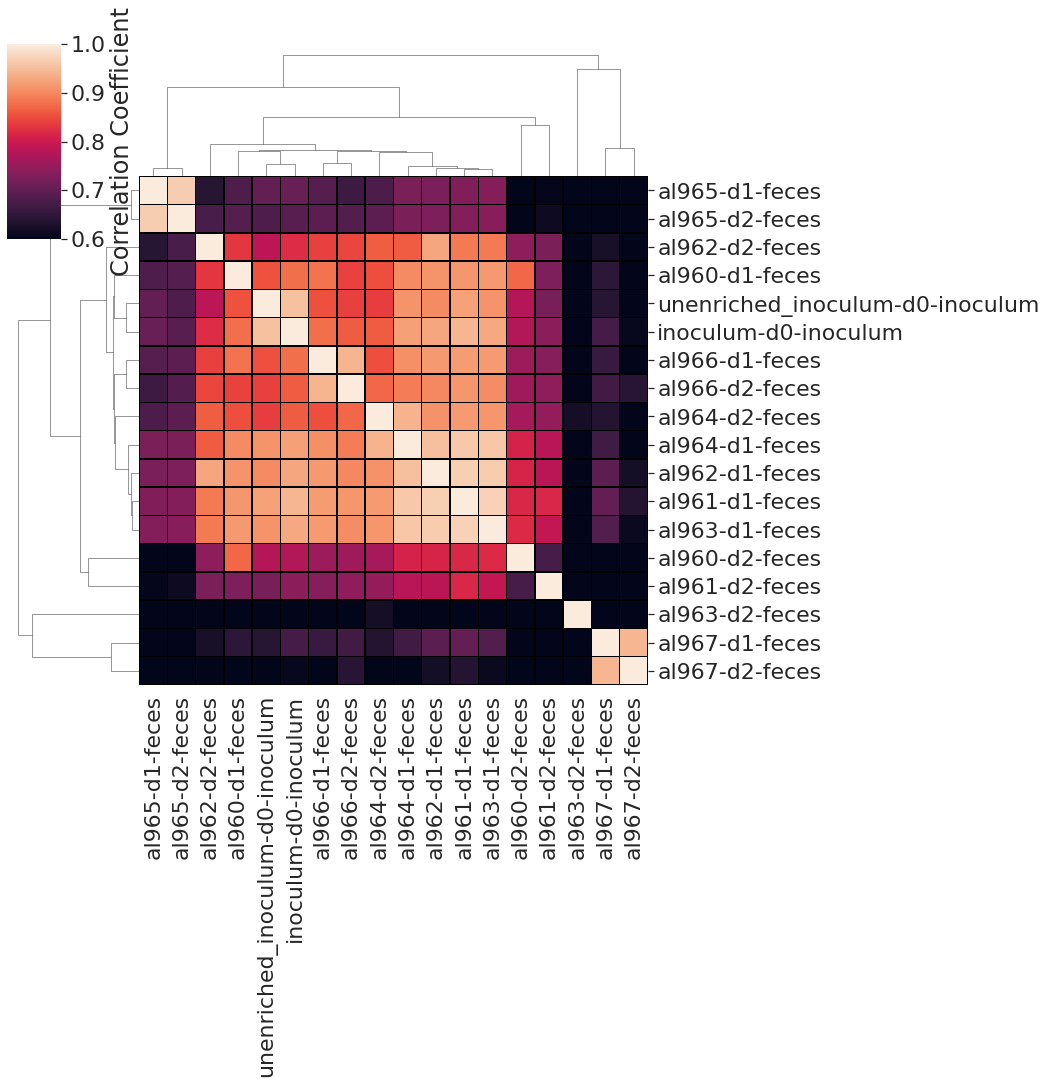

In [11]:
sns.set_style("white")
sns.set_context("notebook", font_scale=2.0)
g = sns.clustermap(df2.corr(), linewidths=0.5, linecolor='black',figsize=(15,15),vmin=0.6, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})

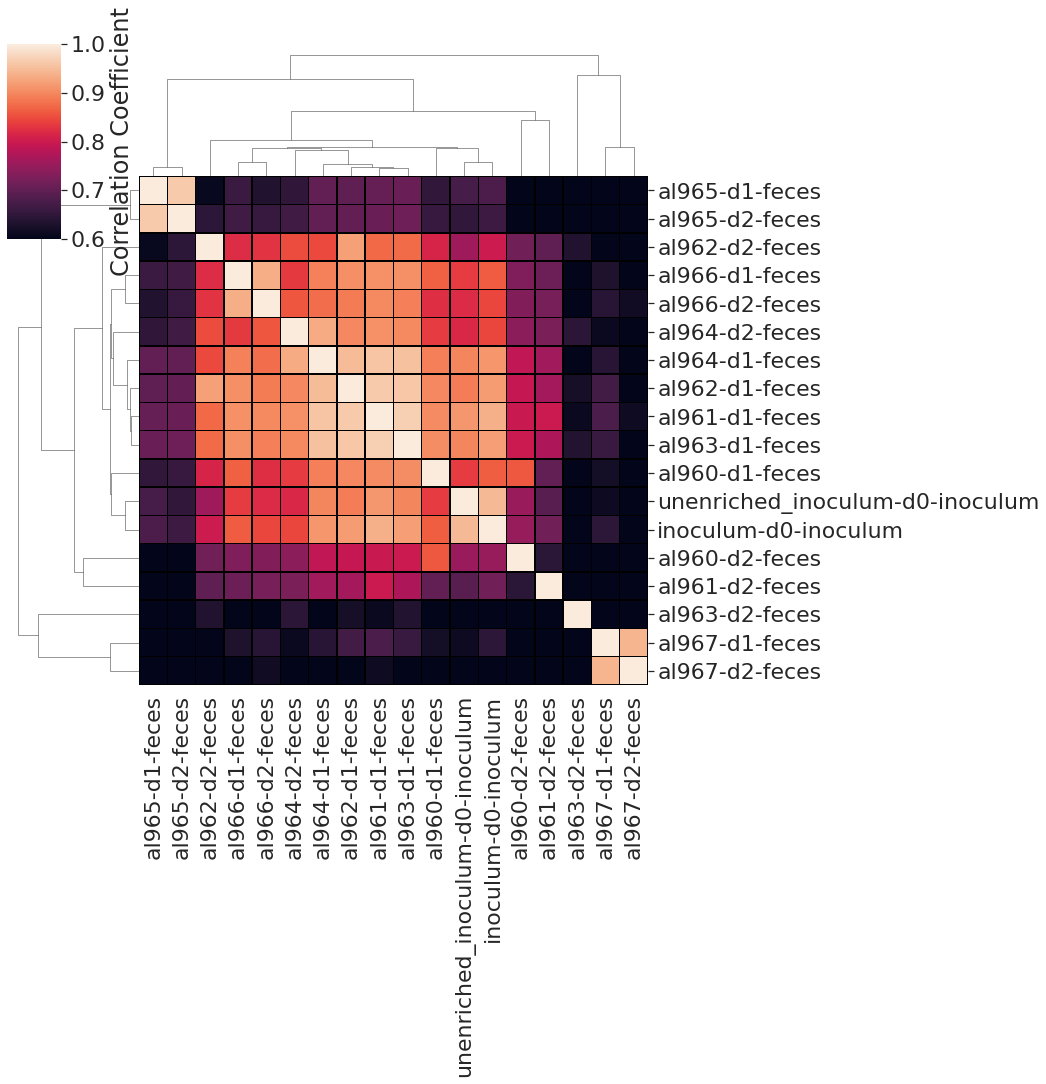

In [86]:
g = sns.clustermap(df.corr(), linewidths=0.5, linecolor='black',figsize=(15,15),vmin=0.6, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})

In [13]:
df1 = df.reset_index()
fdf = pd.melt(df1, id_vars = 'index')
expansion = fdf['variable'].str.split('-', expand=True)
fdf['mouse'], fdf['day'],fdf['organ'] = expansion[0], expansion[1], expansion[2]
meta = fdf.drop(['index', 'value'], axis=1).drop_duplicates().set_index('variable')
#fdf = df2.merge(features[['Feature', 'ShortName']], how='left', left_index=True, right_index=True)
#fdf = fdf.reset_index().rename({'index':'barcode'}, axis=1)

In [14]:
meta

,mouse,day,organ
variable,,,
unenriched_inoculum-d0-inoculum,unenriched_inoculum,d0,inoculum
inoculum-d0-inoculum,inoculum,d0,inoculum
al960-d1-feces,al960,d1,feces
al961-d1-feces,al961,d1,feces
al962-d1-feces,al962,d1,feces
al963-d1-feces,al963,d1,feces
al964-d1-feces,al964,d1,feces
al965-d1-feces,al965,d1,feces
al966-d1-feces,al966,d1,feces


In [15]:
def find_pc1_pc2(df, meta):
    df = df.T
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    pDf = (pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
           .set_index(df.index))
    pc1_var = round(pca.explained_variance_ratio_[0] * 100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1] * 100, 2)
    pDf2 = pDf.merge(meta, left_index=True, right_index=True)
    return pDf2, pc1_var, pc2_var

In [ ]:
pDF, pc1, pc2, = find_pc1_pc2(df3, meta)

In [41]:
pDF, pc1, pc2, = find_pc1_pc2(df3, meta)

In [42]:
pDF

,PC1,PC2,mouse,day,organ
unenriched_inoculum-d0-inoculum,-2.733919,-3.163681,unenriched_inoculum,d0,inoculum
inoculum-d0-inoculum,-3.002483,-4.835038,inoculum,d0,inoculum
al960-d1-feces,-2.356058,-3.039436,al960,d1,feces
al961-d1-feces,-3.234916,-2.991031,al961,d1,feces
al962-d1-feces,-3.386461,-1.996640,al962,d1,feces
al963-d1-feces,-4.506755,-4.779121,al963,d1,feces
al964-d1-feces,-2.774996,-3.746307,al964,d1,feces
al965-d1-feces,30.043888,-1.473413,al965,d1,feces
al966-d1-feces,-2.072109,-1.686209,al966,d1,feces
al967-d1-feces,-2.004920,21.892442,al967,d1,feces


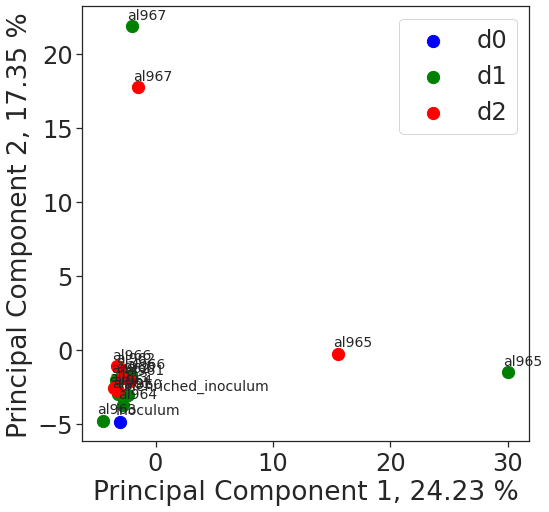

In [45]:
plotPCA(pDF, pc1, pc2, colorby='day', nameby='mouse', col=['blue', 'green', 'red']);


In [23]:
"""
Plotting PCA elipses:
__author__:
"""

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).
    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)


def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip
#____________________________________________________




def plotPCA(pDf, pc1_var, pc2_var, colorby, col, nameby="", el=False):
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=2.2)
    group = pDf[colorby].unique()
    assert len(group) <= len(col)
    fig = plt.figure(figsize=(8, 8))
    for g, c in zip(group, col):
        df = pDf[pDf[colorby] == g]
        x, y = df[["PC1"]].values, df[["PC2"]].values
        ax = plt.scatter(x, y, c=c, s=150, label=g)
        if el:
            pts = np.asarray([[float(a), float(b)] for a, b in zip(x, y)])
            plot_point_cov(pts, nstd=2, alpha=0.1, color=c)
        if nameby:
            labels = df[nameby]
            for label, pc1, pc2 in zip(labels, x, y):
                plt.annotate(label, xy=(pc1, pc2), xytext=(-5, 7), textcoords="offset points",fontsize=14)
        plt.xlabel('Principal Component 1, {} %'.format(pc1_var), )
        plt.ylabel('Principal Component 2, {} %'.format(pc2_var), )
        #plt.xticks(fontsize=16)
        #plt.yticks(fontsize=16)
        plt.legend(frameon=True)
    return fig

In [58]:
controls = pd.read_table('../../data/metadata/controls.txt', header=None, 
                        names = ['DN', 'BC', 'phenotype', 'conc']).set_index('BC')
controls = controls.merge(df, how='left', left_index=True, right_index=True).fillna(0)

controls = controls.melt(id_vars=['DN', 'phenotype', 'conc']).rename({'variable':'sample', 'value':'counts'}, axis=1)
controls.head()

,DN,phenotype,conc,sample,counts
0,1,wt,0.001500,unenriched_inoculum-d0-inoculum,6209.0
1,2,wt,0.000500,unenriched_inoculum-d0-inoculum,2170.0
2,3,wt,0.000167,unenriched_inoculum-d0-inoculum,0.0
3,4,wt,0.000056,unenriched_inoculum-d0-inoculum,167.0
4,5,wt,0.000019,unenriched_inoculum-d0-inoculum,103.0


/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


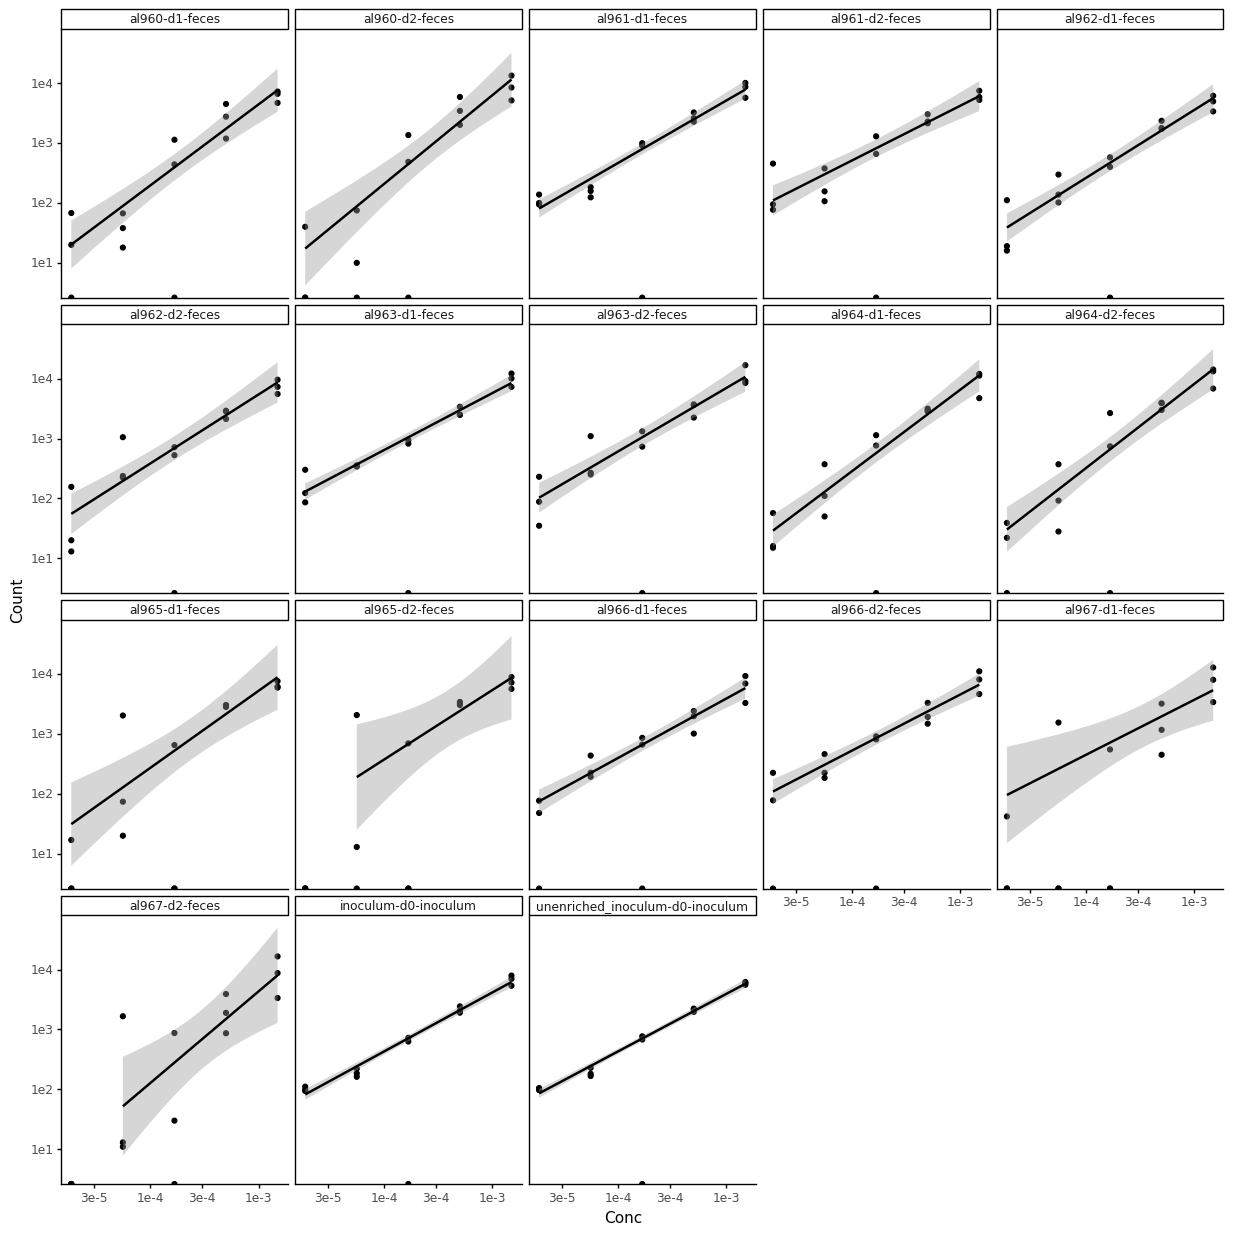

<ggplot: (2977712092317)>

In [81]:
p9.options.figure_size = (15, 15)
(p9.ggplot(controls[controls.phenotype == 'wt'], p9.aes(x='conc', y='counts'))
 #+ p9.geom_line()
 + p9.geom_point()
 +p9.geom_smooth(method = "lm")
 + p9.theme_classic()
 + p9.ylab("Count")
 + p9.xlab("Conc")
 + p9.scale_y_log10()
 + p9.scale_x_log10()
 + p9.facet_wrap('~ sample'))

In [78]:
controls['logConc'] = np.log10(controls['conc'])
controls['logCounts'] = np.log10(controls['counts'])
controls.groupby(['phenotype', 'sample'])[['conc', 'counts']].corr().loc['hyb']

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


conc    counts
sample                                                    
al960-d1-feces                  conc    1.000000  0.993269
                                counts  0.993269  1.000000
al960-d2-feces                  conc    1.000000  0.530681
                                counts  0.530681  1.000000
al961-d1-feces                  conc    1.000000  0.980862
                                counts  0.980862  1.000000
al961-d2-feces                  conc    1.000000  0.979214
                                counts  0.979214  1.000000
al962-d1-feces                  conc    1.000000  0.989524
                                counts  0.989524  1.000000
al962-d2-feces                  conc    1.000000  0.987493
                                counts  0.987493  1.000000
al963-d1-feces                  conc    1.000000  0.999074
                                counts  0.999074  1.000000
al963-d2-feces                  conc    1.000000  0.996039
                                counts  0.996039  1.000000
al964-d1-feces                  conc    1.000000  0.999414
                                counts  0.999414  1.000000
al964-d2-feces                  conc    1.000000  0.993770
                                counts  0.993770  1.000000
al965-d1-feces                  conc    1.000000  0.997772
                                counts  0.997772  1.000000
al965-d2-feces                  conc    1.000000  0.990578
                                counts  0.990578  1.000000
al966-d1-feces                  conc    1.000000  0.987314
                                counts  0.987314  1.000000
al966-d2-feces                  conc    1.000000  0.991398
                                counts  0.991398  1.000000
al967-d1-feces                  conc    1.000000  0.830184
                                counts  0.830184  1.000000
al967-d2-feces                  conc    1.000000  0.995852
                                counts  0.995852  1.000000
inoculum-d0-inoculum            conc    1.000000  0.997878
                                counts  0.997878  1.000000
unenriched_inoculum-d0-inoculum conc    1.000000  0.996802
                                counts  0.996802  1.000000

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars


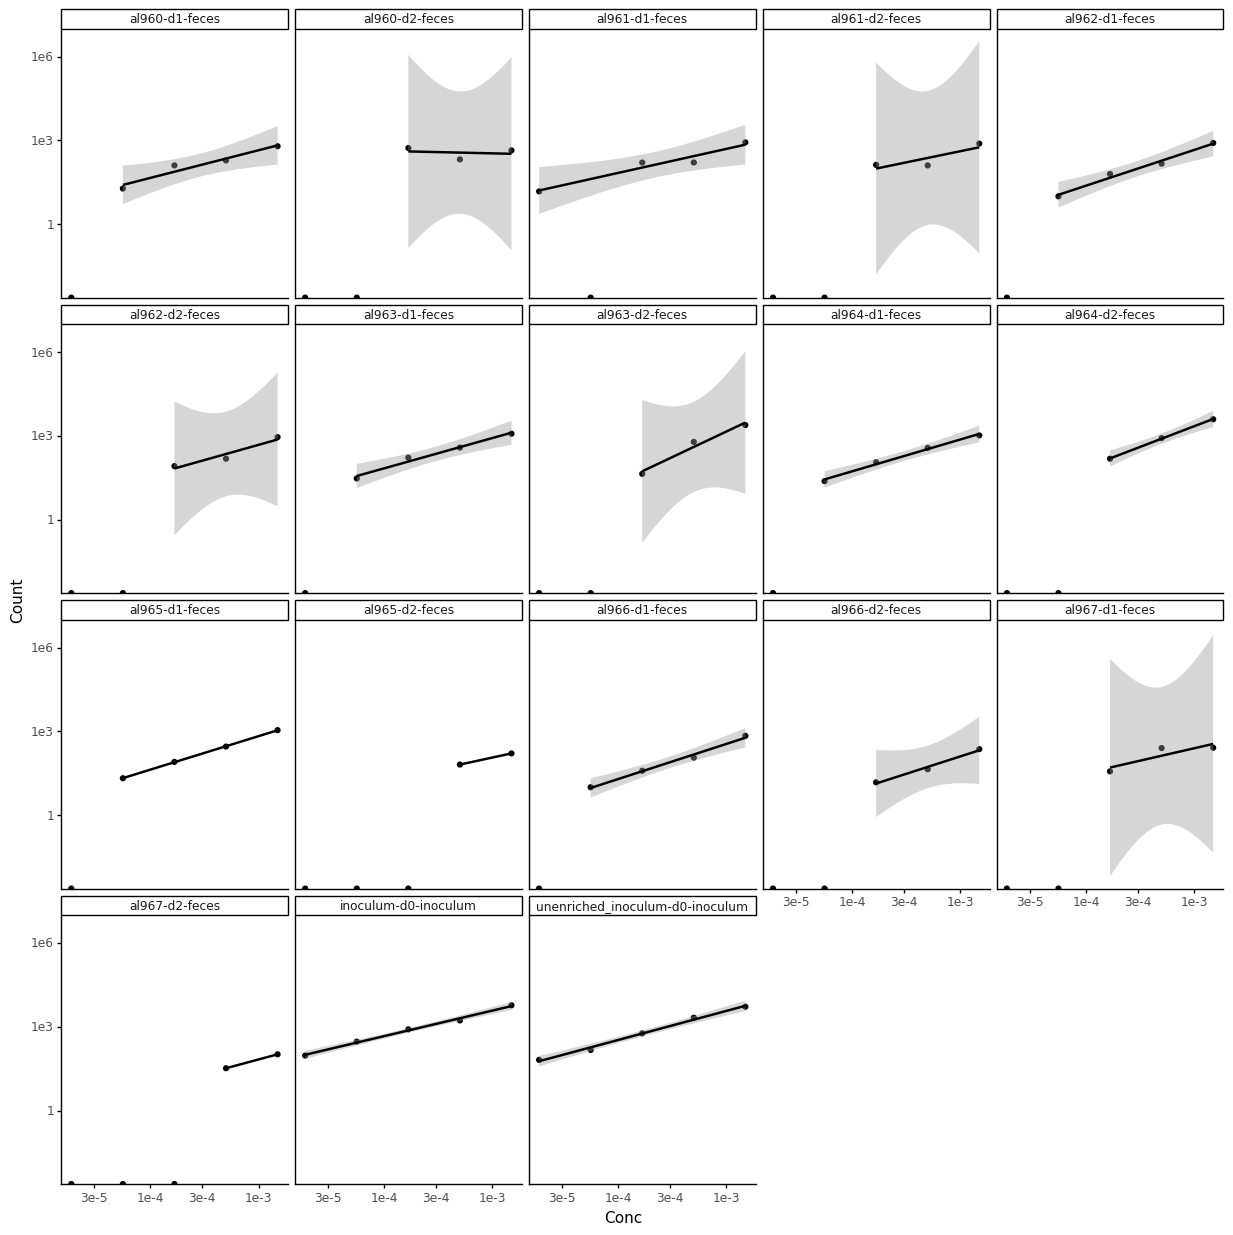

<ggplot: (2977710011254)>

In [82]:
p9.options.figure_size = (15, 15)
(p9.ggplot(controls[controls.phenotype == 'hyb'], p9.aes(x='conc', y='counts'))
 #+ p9.geom_line()
 + p9.geom_point()
 +p9.geom_smooth(method = "lm")
 + p9.theme_classic()
 + p9.ylab("Count")
 + p9.xlab("Conc")
 + p9.scale_y_log10()
 + p9.scale_x_log10()
 + p9.facet_wrap('~ sample'))

In [113]:
wt_corr = controls.groupby(['phenotype', 'sample'])[['logConc', 'logCounts']].corr().loc['wt']
wt_corr = wt_corr.reset_index()
wt_corr = wt_corr[wt_corr['level_1'] == 'logCounts'].drop(['level_1','logCounts'], axis=1)
#wt_corr = wt_corr.stack()
#wt_corr.head()
#wt_corr = wt_corr[wt_corr.index.get_level_values(0) != wt_corr.index.get_level_values(1)]
#wt_corr.index = wt_corr.index.map('_'.join)
#wt_corr = wt_corr.to_frame().drop_duplicates()

array([[<AxesSubplot:title={'center':'logConc'}>]], dtype=object)

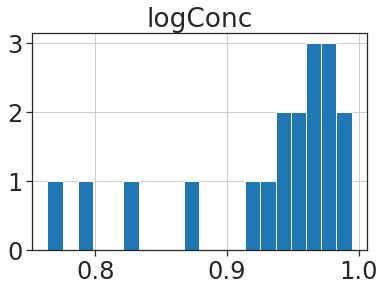

In [105]:
wt_corr.hist(bins=20)

In [114]:
wt_corr = wt_corr.set_index('sample')
wt_corr

,logConc
sample,
al960-d1-feces,0.939624
al960-d2-feces,0.923240
al961-d1-feces,0.981223
al961-d2-feces,0.937930
al962-d1-feces,0.963210
al962-d2-feces,0.930044
al963-d1-feces,0.981734
al963-d2-feces,0.953549
al964-d1-feces,0.966661


array([[<AxesSubplot:title={'center':'inoculum-d0-inoculum'}>]],
      dtype=object)

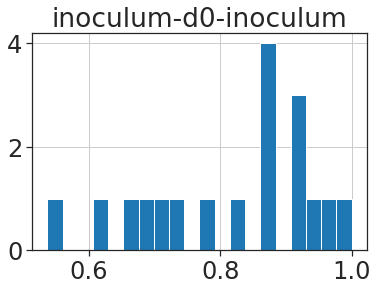

In [119]:
prop_corr = df2.corr()[['inoculum-d0-inoculum']]
#prop_corr = prop_corr.merge(wt_corr, left_index=True, right_index=True)
prop_corr.hist(bins=20)

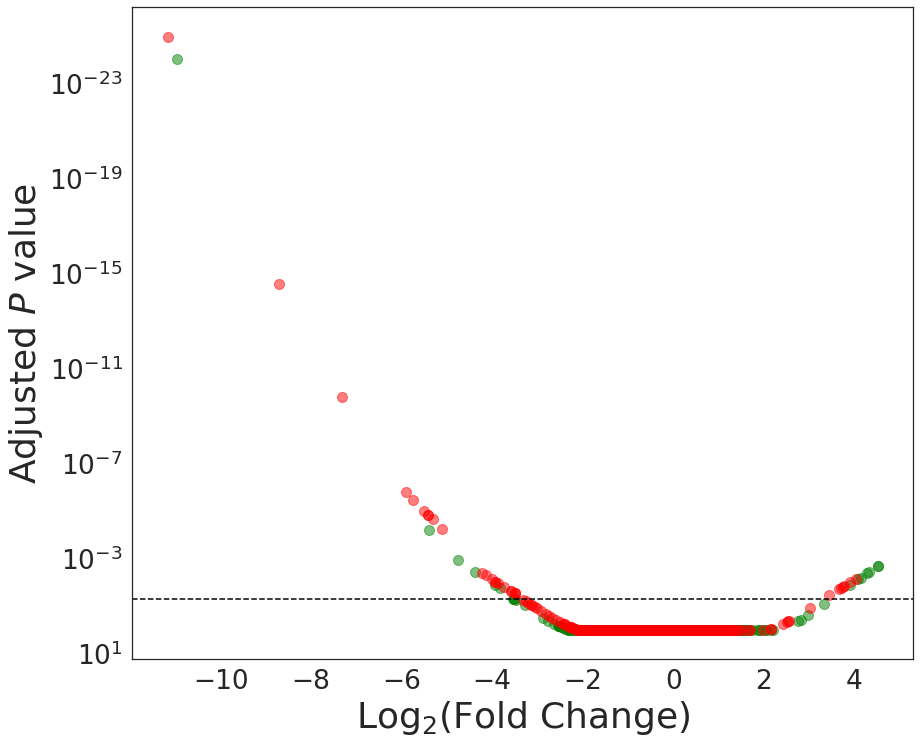

In [110]:
sns.set_context("notebook", font_scale=2.4)
fig = plt.figure(figsize=(14,12))
plt.yscale('log')
#plt.xlim(-8, 8)
plt.rcParams["lines.markersize"] = 10.0
plt.scatter(results.d1_zscore, results.d1_padj, color='green', alpha=0.5, label="Day 1")
plt.scatter(results.d2_zscore, results.d2_padj, color='red', alpha = 0.5, label="Day 2")
#plt.scatter(aa_transp_df.log2FoldChange, aa_transp_df.padj, color="#74d600",  label="Amino Acid Transporters")
#plt.scatter(sugar_aa_met_df.log2FoldChange, sugar_aa_met_df.padj, color=col5, 
#            label="Sugar Catabolism/Amino Acid Biosynthesis")
#plt.scatter(sugar_tt_df.log2FoldChange, sugar_tt_df.padj, color="#00ced1",  label="Sugar Transporters")

#plt.axvline(-2, color='k', linestyle="--",)
#plt.axvline(2, color='k', linestyle="--")
plt.axhline(0.05, color='k', linestyle="--")
plt.xlabel("Log$_2$(Fold Change)", fontsize=36)
plt.ylabel("Adjusted $\itP$ value", fontsize=36)
plt.gca().invert_yaxis()

#plt.legend(markerscale=1.5, frameon=True, facecolor="white", framealpha=0.8, fontsize=24)

#plt.legend(markerscale=1.5, frameon=True, facecolor="white", framealpha=0.5)

In [113]:
results.sort_values(by='d1_padj')

,short_name,tag_counts,d1_zscore,d1_pvalue,d1_padj,d2_zscore,d2_pvalue,d2_padj
gene-SL1344_2332,cvpA,4,-10.973426,5.129136e-28,9.052925e-25,-11.170049,5.714963e-29,1.008691e-25
gene-SL1344_2502,hscB,2,-5.384707,7.256261e-08,6.403650e-05,-5.513425,3.519168e-08,1.035222e-05
gene-SL1344_3500,SL1344_3500,11,-4.753543,1.998830e-06,1.175978e-03,-8.711705,2.993385e-18,2.641662e-15
gene-SL1344_1027,pipB,28,4.521554,6.138719e-06,2.166968e-03,4.040010,5.344903e-05,7.256733e-03
gene-SL1344_2500,fdx,5,4.523381,6.085955e-06,2.166968e-03,3.913737,9.087853e-05,9.435330e-03
...,...,...,...,...,...,...,...,...
gene-SL1344_2443,narQ,7,-0.003683,9.970617e-01,9.988168e-01,-0.050338,9.598528e-01,9.992572e-01
gene-SL1344_4141,gtrAb,18,0.007351,9.941347e-01,9.988168e-01,-0.706004,4.801855e-01,9.992572e-01
gene-SL1344_RS24605,SL1344_RS24605,37,-0.003165,9.974744e-01,9.988168e-01,-0.774997,4.383411e-01,9.992572e-01
gene-SL1344_0309,dbh,21,-0.001334,9.989360e-01,9.989360e-01,-0.878761,3.795308e-01,9.992572e-01


In [152]:
pos_bias = df.merge(features, how='left', left_index =True, right_index = True)
pos_bias = pos_bias[pos_bias.Element == 'FQ312003.1'].sort_values(by='Position')
pos_bias['Position'] = pos_bias['Position']/1000000
pos_bias = pos_bias[pos_bias.sum(axis=1) > 10]

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


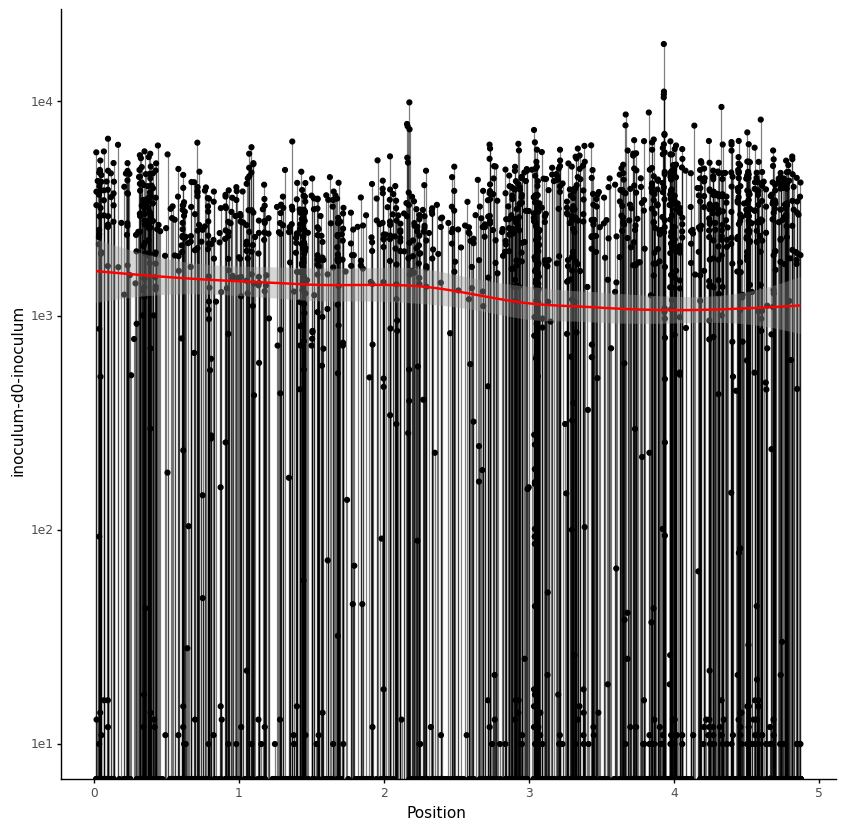

<ggplot: (2977717903854)>

In [158]:
p9.options.figure_size = (10, 10)
(p9.ggplot(pos_bias, p9.aes(x='Position', y='inoculum-d0-inoculum'))
 #+ p9.geom_line()
 + p9.geom_point()
 + p9.geom_segment(p9.aes(x='Position', xend='Position', y='inoculum-d0-inoculum', yend=0), alpha=0.5)
 + p9.theme_classic()
 + p9.geom_smooth(method='loess', color='red')
#  + p9.ylab("Count")
#  + p9.xlab("Conc")
  + p9.scale_y_log10()
)
 #+ p9.scale_color_distiller(palette=1, ))
#  + p9.facet_wrap('~ sample'))

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


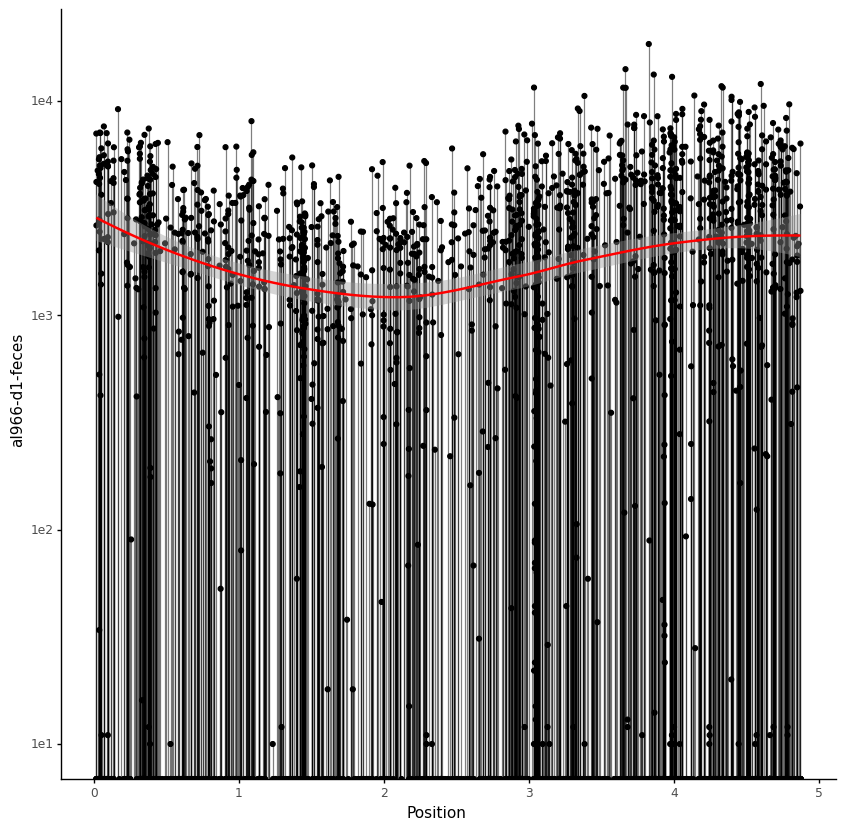

<ggplot: (2977717178631)>

In [157]:
p9.options.figure_size = (10, 10)
(p9.ggplot(pos_bias, p9.aes(x='Position', y='al966-d1-feces'))
 #+ p9.geom_line()
 + p9.geom_point()
 + p9.geom_segment(p9.aes(x='Position', xend='Position', y='al966-d1-feces', yend=0), alpha=0.5)
 + p9.theme_classic()
 + p9.geom_smooth(method='loess', color='red')
#  + p9.ylab("Count")
#  + p9.xlab("Conc")
  + p9.scale_y_log10()
 #+ p9.scale_color_distiller(palette=1, ))
#  + p9.facet_wrap('~ sample'))
)

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


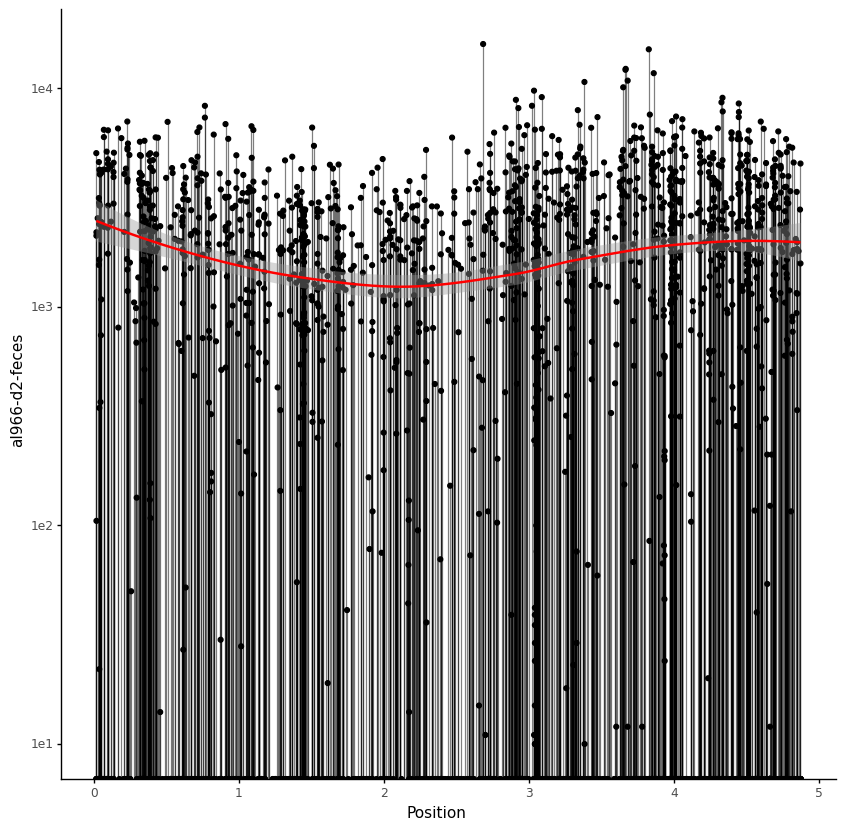

<ggplot: (2977717162060)>

In [159]:
p9.options.figure_size = (10, 10)
(p9.ggplot(pos_bias, p9.aes(x='Position', y='al966-d2-feces'))
 #+ p9.geom_line()
 + p9.geom_point()
 + p9.geom_segment(p9.aes(x='Position', xend='Position', y='al966-d2-feces', yend=0), alpha=0.5)
 + p9.theme_classic()
 + p9.geom_smooth(method='loess', color='red')
#  + p9.ylab("Count")
#  + p9.xlab("Conc")
  + p9.scale_y_log10()
)
 #+ p9.scale_color_distiller(palette=1, ))
#  + p9.facet_wrap('~ sample'))

In [116]:
(p9.ggplot(geneInfo, p9.aes('Feature'))
 + p9.geom_histogram(bins=50, fill='#428bca')
 + p9.theme_classic()
 + p9.ylab("Count")
 + p9.xlab("# of barcodes per feature"))

NameError: name 'geneInfo' is not defined

In [163]:
c1 = abs(results['d1_zscore']) > 2
c2 = results['d1_padj']< 0.05
results['d1_hit'] = c1 & c2
results['d1_-log10Pval'] = -np.log10(results.d1_padj)

/nfs/home/ansintsova/miniconda3/envs/datavis/lib/python3.9/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_label : Removed 6 rows containing missing values.


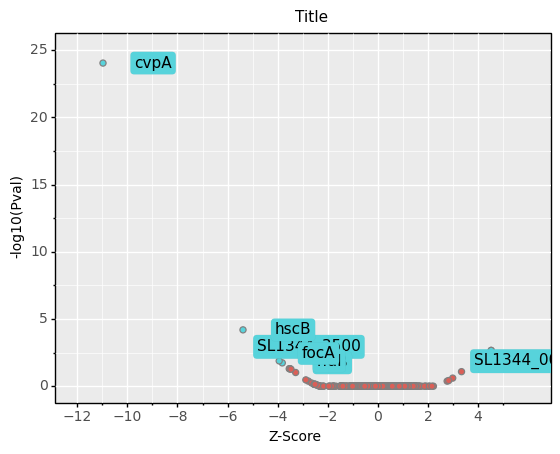

<ggplot: (2961204091094)>

In [193]:

(p9.ggplot(results, p9.aes(x = 'd1_zscore', y = 'd1_-log10Pval', fill='d1_hit')) +
 p9.geom_point(size = 2, shape = 'o', colour = "grey")+
 p9.labs(x = 'Z-Score', y = '-log10(Pval)')+
 p9.scale_x_continuous(limits = [-12, 6], breaks = range(-12, 6, 2)) + 
 p9.scale_y_continuous(limits = [0, 25], breaks = range(0, 26, 5))+
 p9.ggtitle("Title")+
 p9.theme(
    plot_title = p9.element_text(family = "Arial", size = 11, hjust = 0), # Title size and font.
    
    axis_text = p9.element_text(family = "Arial", size = 10), # Size and font of x and y values.
    axis_title = p9.element_text(family = "Arial", size = 10), # Size and font of x and y axes.
    panel_border = p9.element_rect(colour = "black", fill = np.nan, size = 1), # Black border around the plot area.
    axis_ticks = p9.element_line(colour = "black", size = 1), # Style of x and y ticks.
    legend_position = "none"
  )+
   p9.geom_label(p9.aes(label=label), label_size=0.01, nudge_x=2,))#, adjust_text={'expand_points': (1.5, 1.5), 'arrowprops': {'arrowstyle': '-'}}))
  #p9.scale_fill_manual(breaks = ["blue", "red"], values = ["deepskyblue3", "firebrick1"]))



In [136]:



  #geom_hline(yintercept = 1.30103, colour = "black", linetype = "dashed", size = 0.75) + # Horizontal significance cut-off line.
  #geom_vline(xintercept = 0.584963, colour = "black", linetype = "dashed", size = 0.75) + # Vertical significance cut-off line (+).
  # geom_vline (xintercept = -0.584963, colour = "black", linetype = "dashed", size = 0.75) #Vertical significance cut-off line (-)

  #scale_fill_manual(breaks = c("blue", "red"), values = c("deepskyblue3", "firebrick1")) + # Costum colors of data points based on "PursFur" column.

  #geom_text(aes(label = ifelse(PursFur == 1, as.character(Protein.ID), "")), hjust = 0, vjust = -0.25) + # Add identifiers to a subset of data points.

  #annotate("text", x = 2.9, y = 1.45, label = "P = 0.05", size = 4, fontface = "bold") + # Label to horizontal cut-off line.
  #annotate("text", x = 0.68, y = 5.9, label = "1.5-fold", size = 4, fontface = "bold", srt = 90) + # Label to vertical cut-off line.
  #annotate("rect", xmin = 0.584963, xmax = 3, ymin = 1.30103, ymax = 6, alpha = .2)) # Shade plot subregion.

[-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

In [171]:
results.loc['gene-SL1344_RS24690']['d1_hit']

False

In [189]:
label = [results.loc[i]['short_name'] if results.loc[i]['d1_hit'] else '' for i in results.index  ]

In [178]:
label

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'gene-SL1344_3500',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'gene-SL1344_3685',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'gene-SL1344_0016',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '